# RC FILTERS
## Numerically calculating the response of an RC filter network

We can use the impedance definition for a capacitor (or an inductor) to work out the response of an RC (or RL or RLC) network. The initial math is similar to the resistor networks, but now instead of R we have Z, and complicating things a little, Z is complex. The frequency response, in a Bode plot, can be worked out using the FFT tools of Python's SciPy.

First, the simplest low pass filter is a resistor and a capacitor to ground. Like this:
<img src="rc_filter_circuit.pdf" alt="Low Pass RC Filter" style="width: 200px;"/>
For the analysis of this circuit, we first need to remember that for a resistor $Z_R = R$, and for a capacitor $Z_C = \frac{-j}{\omega C}$. The circuit forms just a voltage divider, but now with a capacitor replacing the second resistor. If the input to our circuit is a pure sinusoidal signal, then we can compute the output voltage as:
$$ V_{out}(t) = V_{in}(t) \left(\frac{Z_C}{Z_R + Z_C} \right)= V_{in}(t)\left(\frac{-j/\omega C}{R- j/\omega C} \right) = V_{in}(t)\left(\frac{1}{jR\omega C +1} \right)  $$
We could simplify this statement, or just enter it as a Python formula as is.

To do this we need to first learn about complex numbers in Python. Actually, they are really easy, if we use Numpy (or Scipy). The complex number is just $\sqrt{-1} = 1j$, so that:

In [1]:
1j*1j

(-1+0j)

As expected the square is minus one. We can now define the RC circuit as function of the frequency, where $f=\omega/2\pi$, and for simplicity we choose $V_in=1$.

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
def Filter(f):                     # Define the Filter function that corresponds to the low pass RC filter.
    R=1000.
    C=1e-6
    omega = 2*np.pi*f
    vout=( 1/(1j*R*omega*C+1))
    return(vout)

We now plot this function versus frequency, on a semi log plot, where the x axis is logarithmic. This *should* look like the plot created with the sweep simulation at: https://www.partsim.com/simulator#66937.

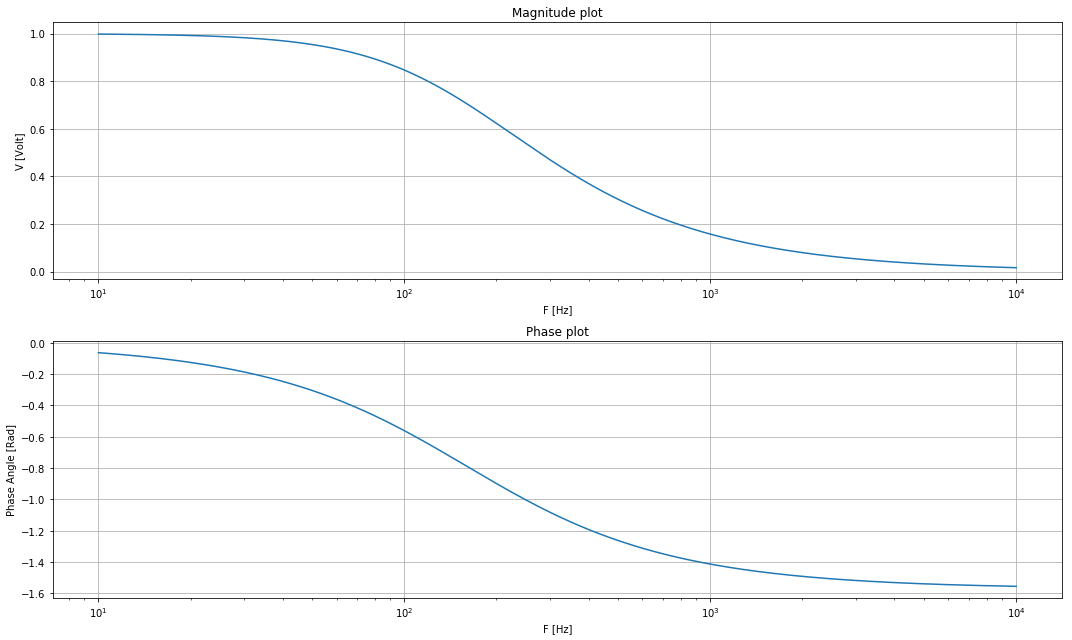

In [10]:
f = np.linspace(10,1e4,1e4)
vout_c = Filter(f)
plt.figure(figsize=(15,9)) # Make a figure, and make it bigger.
plt.subplot(2,1,1)         # First subplot in the figure with (2 columns, 1 row, 1st subplot)
plt.plot(f,np.abs(vout_c)) # Plot the amplitude, the absolute of the complex number
plt.title("Magnitude plot")
plt.xlabel("F [Hz]")
plt.ylabel("V [Volt]")
plt.xscale("log")           # Set x to a log scale
plt.grid(True)
plt.subplot(2,1,2)
plt.plot(f,np.angle(vout_c)) # Plot the amplitude, the absolute of the complex number
plt.title("Phase plot")
plt.xlabel("F [Hz]")
plt.ylabel("Phase Angle [Rad]")
plt.xscale("log")
plt.grid(True)
plt.tight_layout()          # Automatically adjust spacing between the 2 plots so they do not overlap
plt.show()

To make this a Bode plot, we would want to plot the y axis as: $$ 20\log_{10}\left( \left| \frac{V_{out}}{V_{in}}\right|\right)$$, which is the signal in deciBel, or dB. To get our axis in that scale, we want to put the data through the formula. Here is the plot:

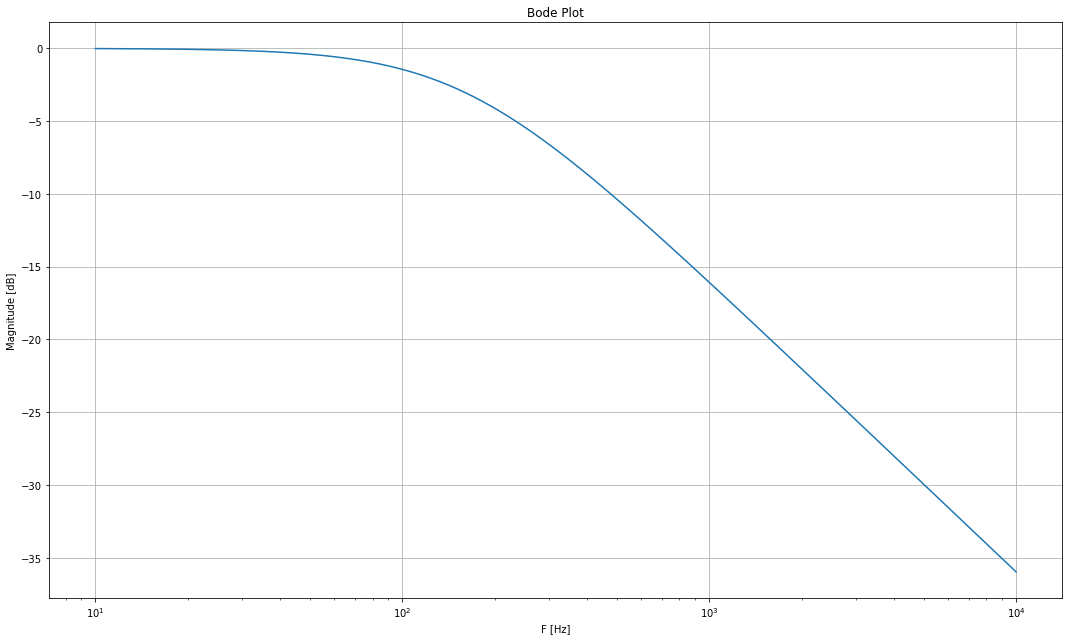

In [11]:
y_db = 20*np.log10(np.abs(vout_c))
plt.figure(figsize=(15,9)) # Make a figure, and make it bigger.
plt.plot(f,y_db) # Plot the amplitude, the absolute of the complex number
plt.title("Bode Plot")
plt.xlabel("F [Hz]")
plt.ylabel("Magnitude [dB]")
plt.xscale("log")           # Set x to a log scale
plt.grid(True)
plt.tight_layout()          # Automatically adjust spacing between the 2 plots so they do not overlap
plt.show()

# Fourier Analysis of a Filter

Knowing the frequency response of a circuit, begs the question how an actual signal changes when it is passed through this circuit. Here we will answer the question "What would a square wave look like if I send it through this filter?" Once you know how to do this, you can extend it to any input waveform.

To brush up on FFTs, look at the [FFT tutorial notebook](https://github.com/mholtrop/Phys605/blob/master/Python/FFT/FFT%2Bexample1.ipynb). Once you understand the Fourier Theorem, you should have little problem with this filter example.

Here is the input waveform. We will use scipy.signal to help us calculate it, but you could also write your own fun

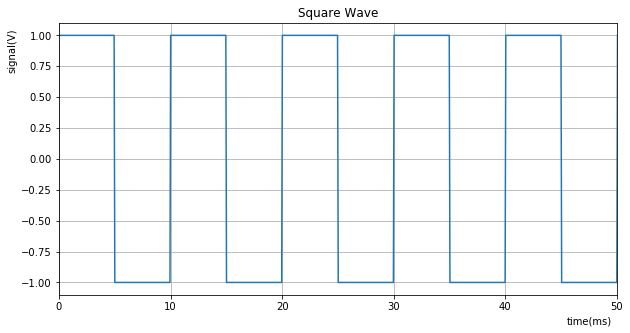

In [12]:
from scipy.fftpack import fft, ifft, fftfreq, fftshift
from scipy import signal
F = 100.
T = 2.
N = 2**15                         # You can do FFTs over any number, but 2^N (2**N) is *a lot* faster!
DT = T/N
t = np.linspace(0.,T,N)
y_sq = signal.square(2*np.pi*F*t) # Create a square wave wiht a 2 Volt peak to peak (-1V to +1V)
plt.figure(figsize=(10,5))
plt.plot(1000*t,y_sq)             # Change the x-axis scale to ms by multiplying by 10^3
ax = plt.gca()
ax.set_xlim(0.,50.)               # Show only the first 50 ms of the signal
plt.grid(True)
plt.title("Square Wave")
plt.xlabel("time(ms)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
plt.show()

This is the same square wave waveform that we had before, but this time to show the effect better, I increased the frequency of the signal to 100 Hz, and plot only 0.06 sec worth of this signal.

To see what that signal looks like after our RC Filter, we need to first compute the FFT of our signal. We now essentially have the signal broken down into a very large number of sine waves, all of which need to be added together to give the signal shown above. We do this, because we only could compute what our RC filter does for a *sine* wave, and not any other shape wave. If we now multiply each of these sine waves with the function for the RC filter that we computed before, would get our output signal in the frequency domain. We then take the reverse FFT to reconstruct the signal in the time domain, which is the signal after the RC filter as you would see it on a oscilloscope.

Note the use of fftfreq, which gets us the list of frequencies. Also note that for Numpy arrays, $A*B$ is the sequential multiplication of each element of array A with the corresponding element of array B, which is exactly what we want here. Check if this output indeed corresponds with what you see on the oscilloscope.

In [1]:
f_fft = fftfreq(N,DT)
y_sq_fft = fft(y_sq)
y_sq_fft_out = y_sq_fft*Filter(f_fft)
y_sq_out = ifft(y_sq_fft_out)
plt.figure(figsize=(10,5))
plt.plot(1000*t,np.real(y_sq_out))
ax = plt.gca()
ax.set_xlim(0.,50.)               # Show only the first 50 ms of the signal
plt.grid(True)
plt.title("Square wave after low-pass filter")
plt.xlabel("time(ms)",position=(0.95,1))
plt.ylabel("signal(V)",position=(1,0.9))
plt.show()

NameError: name 'fftfreq' is not defined

You can load this notebook in Jupyter and run it on your own computer. Note how you get some *artifacts* in the output if you reduce the number of points in the FFT. Those artifacts are *similar* to the artifacts you see on a digital scope with a limited sampling frequency. Very expensive digital scopes overcome this by having larger buffers and higher sampling frequencies. 

You can now also change the parameters of your filter, try different values of $R$ and $C$. If you take values that are too low or too high, the simulation will become unrealistic compared to an actual circuit on a breadboard, due to other effects (parasitic capacitance and resistance) on the breadboard that are not included in your simulation.

Check the documentation of scipy.signal and you can try other waveform shapes. You can also change the circuit and look at a high-pass instead of a low pass filter. For more complicated filters, band-pass, 2nd or 3rd order, filters with active components, the math for the filter function gets more and more complicated, but essentially it is just and extension of what we did here.